In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import vaemof
from vaemof import experiments
from vaemof import utils
from vaemof.vocabs import SELFIESVocab, MOFVocab, PropVocab
from vaemof import modules
from vaemof import training
from vaemof.model import VAEMOF
from vaemof import configs

from vaemof.utils import header_str
vaemof.experiments.plot_settings()

RDKit WARNING: [02:06:24] Enabling RDKit 2019.09.3 jupyter extensions
/home/beangoben/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
import os
from tqdm.auto import tqdm
import numpy as np
import torch
import rdkit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

print(f'rdkit : {rdkit.__version__}')
print(f'torch : {torch.__version__}')
print(f'cuda? {torch.cuda.is_available()}')
tqdm.pandas()
utils.disable_rdkit_log()

rdkit : 2019.09.3
torch : 1.4.0
cuda? False


## Hparams

In [4]:
preset = 'mof_y'
WORK_DIR = 'results/test'
hparams = configs.get_model_config(WORK_DIR, preset)
print(utils.header_str(preset))
hparams['train_device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

testing = configs.testing_config(hparams)
configs.print_config(hparams)
utils.set_seed(hparams['train_seed'])
device = torch.device(hparams['train_device'])

==================================== mof_y =====================================
==================================== config ====================================
== train == :
        train_device:                 cpu
          train_seed:                  42
    train_batch_size:                  64
        train_epochs:                  20
            train_lr:               0.005
     train_clip_grad:                  20
== vae == :
      vae_latent_dim:                 256
           vae_y_dec:                True
     vae_selfies_dec:               False
         vae_mof_enc:                True
         vae_mof_dec:               False
vae_duplicate_smiles:                True
== mof == :
        mof_encoding:                 all
   mof_weighted_loss:                True
         mof_w_start:                 0.0
           mof_w_end:                 1.0
           mof_start:                  15
    mof_const_length:                  10
== y == :
            y_labels:['lcd', 'pld'

## Load MOF data

Assemble smiles formula: [organic core][metal_node][topology][branch_smiles]

In [5]:
smiles_column = 'branch_smiles'
testtrain_column = 'train/test'
df = experiments.get_generator_df(csv_file=hparams['files_data'],
                                  smiles_column=smiles_column,
                                  use_duplicates=hparams['vae_duplicate_smiles'],
                                  testing=testing)
ids2mofs, mof2ids, mof_columns = experiments.get_mofdict(
    df, hparams['mof_encoding'])
df.head()

=================================== Testing ====================================
df shape: (713, 9)
df columns: ['index', 'branch_smiles', 'id2mof', 'metal_node', 'mof_index', 'organic_core', 'randomized', 'topology', 'train/test']
Found 713 unique mofs


,index,branch_smiles,id2mof,metal_node,mof_index,organic_core,randomized,topology,train/test
0,0,CC(c1cc(O)cc(O)c1)(C(Sc1cc(O)cc(O)c1)c1cc(O)cc...,0,sym_7_mc_4,4.0,None,False,acs,1
1,2140,O=C1OC2C3(CC([Lr])C2(S(=O)(=O)O)S(=O)(=O)O)C(C...,1,sym_8_mc_7,30198.0,None,False,bcu,1
2,4280,CP(C)c1cc2c(c(P(C)C)c1)N=C(Nc1cc(P(C)C)c([Lr])...,2,sym_8_mc_8,60377.0,None,False,bcu,1
3,6420,CC(c1cc(O)cc(O)c1)(C(Sc1cc(O)cc(O)c1)c1cc(O)cc...,3,sym_8_mc_9,90517.0,None,False,bcu,1
4,8560,O=C1c2cc(-c3cc(O)cc(O)c3)c([Lr])cc2C(c2cc(O)cc...,4,sym_16_mc_6,120699.0,None,False,bcs,1


## Load property data

In [6]:
prop_df = experiments.get_prop_df(csv_file=hparams['files_prop'],
                                  targets=hparams['y_labels'],
                                  mof2ids=mof2ids,
                                  testing=testing,
                                  smiles_column=smiles_column,
                                  compute_scscore=True)
prop_df.head()

=================================== Testing ====================================
Restored variables from data/scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz



Removed 68 datapoints due to mask.
Removed 40 datapoints due non-valid mof (mof2ids).
Removed 4 datapoints due to high selectivity.


,organic_core,metal_node,topology,branch_smiles,lcd,pld,density,avf,avsa,agsa,...,co2ch4_selectivity,co2ch4_heat_avg,co2ch4_heat_co2,co2ch4_heat_ch4,co2ch4_heat_molfrac,selfies_safe,mask,train/test,scscore,id2mof
0,sym_5_vae_70,sym_8_mc_7,scu,[Lr]c1ccc(o1)[Lr],6.92684,3.03360,1.143760,0.00000,0.000,0.00,...,0.000000,0.00000,0.00000,0.00000,0.00000,True,True,1,1.466316,451
1,sym_5_vae_1038,sym_5_mc_2,ssa,[Lr]c1sc(c2c1OCCO2)[Lr],22.43124,20.60178,0.421659,0.56582,1624.620,3852.92,...,3.036957,-12.71150,-18.03664,-11.03007,-12.79457,True,True,0,2.445184,405
2,sym_4_vae_153,sym_9_mc_5,iac,[Lr]c1ccc(cc1)C#C[Lr],14.39486,12.29328,0.468486,0.54877,1846.740,3941.94,...,2.246914,-10.97052,-14.84627,-9.85140,-10.84985,True,True,1,1.743814,186
3,sym_5_vae_BR3264,sym_9_mc_5,soc,[Lr]c1c(C)nn([Lr])c1C,13.94895,10.49463,0.659699,0.41073,1831.680,2776.53,...,4.668019,-16.33142,-22.63069,-13.42098,-16.57039,True,True,1,2.306571,509
4,sym_5_vae_795,sym_4_mc_1,pth,O=C1c2c(c3ccc([Lr])cc31)ccc([Lr])c2,23.45655,21.13022,0.146984,0.78696,967.072,6579.45,...,1.855461,-8.26031,-11.89364,-7.56506,-8.30322,True,True,1,3.012280,257


## Train/test splits and hparams

In [7]:
train_index = np.array(df[df[testtrain_column] == 1].index.tolist())
test_index = np.array(df[df[testtrain_column] == 0].index.tolist())
prop_train_index = np.array(
    prop_df[prop_df[testtrain_column] == 1].index.tolist())
prop_test_index = np.array(
    prop_df[prop_df[testtrain_column] == 0].index.tolist())
print(f'Train sizes: {len(train_index):7d} and {len(prop_train_index):7d}')
print(f'Test  sizes: {len(test_index):7d} and {len(prop_test_index):7d}')

Train sizes:     657 and     802
Test  sizes:      56 and      86


# Vocabulary and preprocessors

In [8]:
smiles_list = df[smiles_column].tolist()+prop_df[smiles_column].tolist()
vocab = SELFIESVocab.from_data(smiles_list)
vocab_mof = MOFVocab.from_data(df.append(
    prop_df, sort=False), mof_columns, weighting=hparams['mof_weighted_loss'])
vocab_y = PropVocab.from_data(
    prop_df, hparams['y_labels'], hparams['y_weights'])
vocab, vocab_mof, vocab_y


Alphabet size is 44
Max seq length is 106 with 5 extra padding
Used columns =['metal_node', 'organic_core', 'topology', 'id2mof'] with frequency weighting=True
metal_node   has 15 classes
organic_core has 52 classes
topology     has 41 classes
id2mof       has 713 classes


(<vaemof.vocabs.SELFIESVocab at 0x7fc7861f8990>,
 <vaemof.vocabs.PropVocab at 0x7fc7859f4550>)

# Instanciate Model

## Careful! (it saves and will overwrite any model previously saved)

In [17]:
try:
    utils.clear_torch(model)
except:
    utils.clear_torch(model=None)

model = VAEMOF(hparams, vocab, vocab_mof, vocab_y).to(device)
model.save()
modules.model_summary(model, include_children=False)

,Name,Module,Extra,submodule,trainable,n_params,trainable_params
0,z_mu,Linear,"in_features=512, out_features=256, bias=True",False,True,131328,131328
1,z_logvar,Linear,"in_features=512, out_features=256, bias=True",False,True,131328,131328
2,enc_x,CharEncoder,,False,True,364601,364601
3,enc_mof,MOFEncoder,,False,True,407552,407552
4,dec_y,PropDecoder,,False,True,5418,5397


Trainable params: 1040206 out of 1040227 total (100.00%)


## Prepare train/test 

In [10]:
train_mof = model.df_to_tuples(df.loc[train_index], smiles_column)
test_mof = model.df_to_tuples(df.loc[test_index], smiles_column)
prop_train = model.df_to_tuples(prop_df.loc[prop_train_index], smiles_column)
prop_test = model.df_to_tuples(prop_df.loc[prop_test_index], smiles_column)
train_data = train_mof + prop_train
test_data = test_mof + prop_test

## Train

In [18]:
trainer = training.Trainer(hparams)
trainer.train(model, train_data, test_data)

# Results
## Load saved model

In [19]:
hparams_file = os.path.join(WORK_DIR,'config.json')
hparams = configs.AttributeDict.from_jsonfile(hparams_file)
model = VAEMOF.load(hparams)

## Training stats

In [26]:
log_df = pd.read_csv(configs.at_results_dir(hparams,'files_log'))
log_df = log_df.drop(columns=[c for c in log_df.columns if any(l in c for l in ['mof','x', 'kl','ratio'])])
print(log_df.shape)
print(log_df.columns)
log_df.head()

(20, 50)
Index(['epoch', 'test_y', 'test_loss', 'lcd-r2', 'lcd-MAE', 'pld-r2',
       'pld-MAE', 'density-r2', 'density-MAE', 'avf-r2', 'avf-MAE', 'avsa-r2',
       'avsa-MAE', 'agsa-r2', 'agsa-MAE', 'co2n2_co2_mol_kg-r2',
       'co2n2_co2_mol_kg-MAE', 'co2n2_n2_mol_kg-r2', 'co2n2_n2_mol_kg-MAE',
       'co2n2_selectivity-r2', 'co2n2_selectivity-MAE', 'co2n2_heat_avg-r2',
       'co2n2_heat_avg-MAE', 'co2n2_heat_co2-r2', 'co2n2_heat_co2-MAE',
       'co2n2_heat_n2-r2', 'co2n2_heat_n2-MAE', 'co2n2_heat_molfrac-r2',
       'co2n2_heat_molfrac-MAE', 'co2ch4_co2_mol_kg-r2',
       'co2ch4_co2_mol_kg-MAE', 'co2ch4_ch4_mol_kg-r2',
       'co2ch4_ch4_mol_kg-MAE', 'co2ch4_selectivity-r2',
       'co2ch4_selectivity-MAE', 'co2ch4_heat_avg-r2', 'co2ch4_heat_avg-MAE',
       'co2ch4_heat_co2-r2', 'co2ch4_heat_co2-MAE', 'co2ch4_heat_ch4-r2',
       'co2ch4_heat_ch4-MAE', 'co2ch4_heat_molfrac-r2',
       'co2ch4_heat_molfrac-MAE', 'scscore-r2', 'scscore-MAE', 'lr', 'λ_y',
       'train_y', 'train_

,epoch,test_y,test_loss,lcd-r2,lcd-MAE,pld-r2,pld-MAE,density-r2,density-MAE,avf-r2,...,co2ch4_heat_ch4-MAE,co2ch4_heat_molfrac-r2,co2ch4_heat_molfrac-MAE,scscore-r2,scscore-MAE,lr,λ_y,train_y,train_loss,mean_r2
0,0,9.545484,9.545484,0.991675,38.188606,0.753698,180.843719,0.975511,58.397797,0.999816,...,21.539017,0.960311,45.319965,0.848697,70.802002,0.005,1.0,24.347307,24.347307,0.945763
1,1,8.752435,8.752435,0.891332,101.486130,0.897277,113.828636,0.857138,101.464958,0.977589,...,57.500179,0.914056,64.310127,0.995727,13.850142,0.005,1.0,17.754093,17.754093,0.927297
2,2,7.937070,7.937070,0.995204,28.137308,0.897766,113.631630,0.999788,6.316831,0.916561,...,61.668423,0.999571,5.360663,0.962480,46.767902,0.005,1.0,16.027263,16.027263,0.949230
3,3,7.177501,7.177501,0.981366,56.081352,0.970608,58.935894,0.970664,58.744976,0.938899,...,27.900812,0.996695,11.716887,0.979041,34.394054,0.005,1.0,14.998045,14.998045,0.935671
4,4,8.207352,8.207352,0.966440,73.397911,0.886998,117.595543,0.978708,49.245129,0.834980,...,74.018646,0.919310,64.719223,0.942721,51.215454,0.005,1.0,13.095436,13.095436,0.925856


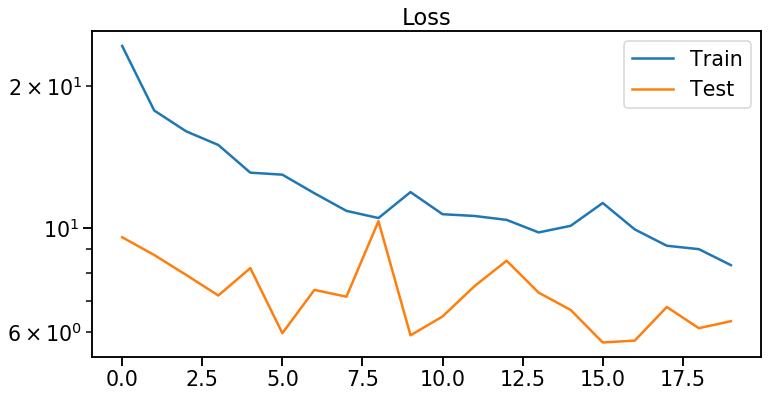

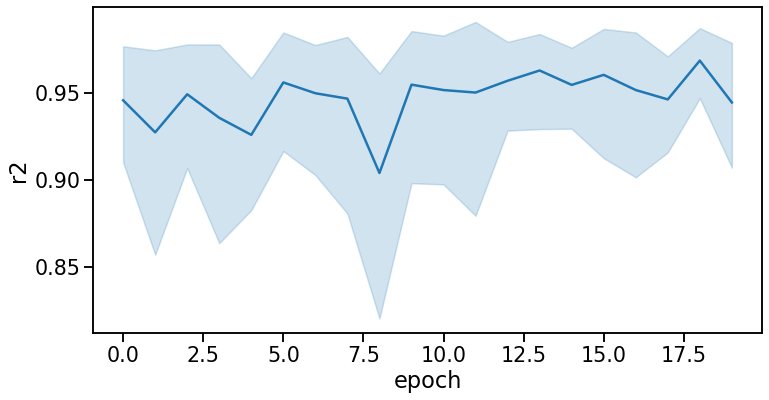

In [27]:
COMPONENTS = training.COMPONENTS
epochs = log_df['epoch'].values

plt.plot(epochs, log_df[f'train_y'], label='Train')
plt.plot(epochs, log_df[f'test_y'], label='Test')
plt.title(f'Loss')
plt.yscale("log")
plt.legend()
plt.show()

results=[]
for label in hparams['y_labels']:
    metric = f'{label}-r2'
    results.extend([{'epoch':epoch,'r2':value,"prop":label} for epoch, value in log_df[['epoch',metric]].values ]  )
prop_df = pd.DataFrame(results)
sns.lineplot(x='epoch',y='r2', data=prop_df)
plt.show()